In [6]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import math
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
# tsv to Dataframe
df_train = pd.read_csv('../data/raw/train.tsv',sep='\t')
df_test = pd.read_csv('../data/raw/test.tsv',sep='\t')

In [8]:
# Feature engineering from datetime
# https://adtech.cyberagent.io/techblog/archives/259
# https://note.nkmk.me/python-pandas-datetime-timestamp/
def create_date_future(df):
    df['datetime'] = pd.to_datetime(df['datetime']) # dtypeをdatetime64に変換
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek  

In [9]:
create_date_future(df_train)
create_date_future(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3
2,2015-01-01,日光国立公園,29714,2015,1,1,3
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3


In [64]:
# label encoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

def onehot_encdr_park(df):
    le = preprocessing.LabelEncoder()
    le.fit(df['park'])
    le.transform(['阿寒摩周国立公園', '十和田八幡平国立公園', '日光国立公園', '伊勢志摩国立公園','大山隠岐国立公園','阿蘇くじゅう国立公園', '霧島錦江湾国立公園', '慶良間諸島国立公園']) 
    
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['park'])
    df_park = pd.DataFrame(park_onehot,columns=le.classes_)
    df = pd.concat([df,df_park],axis=1)
    return df

In [65]:
df_train = onehot_encdr_park(df_train)
df_test = onehot_encdr_park(df_test)
df_train

ValueError: y contains new labels: ['a']

In [12]:
def onehot_encdr_dayofweek(df):
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['dayofweek'])
    df_park = pd.DataFrame(park_onehot,columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    df = pd.concat([df,df_park],axis=1)
    return df

In [13]:
df_train = onehot_encdr_dayofweek(df_train)
df_test = onehot_encdr_dayofweek(df_test)
df_train

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,2015-01-01,阿蘇くじゅう国立公園,1369,2015,1,1,3,0,0,0,...,0,1,0,0,0,0,1,0,0,0
6,2015-01-01,霧島錦江湾国立公園,35352,2015,1,1,3,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7,2015-01-01,慶良間諸島国立公園,151,2015,1,1,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,2015-01-02,阿寒摩周国立公園,11153,2015,1,2,4,0,0,0,...,1,0,0,0,0,0,0,1,0,0
9,2015-01-02,十和田八幡平国立公園,33795,2015,1,2,4,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
# holiday data
df_holiday = pd.read_csv('../data/raw/holiday.csv')
df_holiday['datetime'] = pd.to_datetime(df_holiday['datetime'])
df_holiday.columns

Index(['datetime', 'holiday'], dtype='object')

In [29]:
# 防災科学技術研究所 ⼤⼭鏡ヶ成積雪気象観測施設における積雪気象観測データ
# 日ごとの積雪量の平均データを作成
df_nied_oyama = pd.read_csv('../data/raw/nied_oyama.tsv',sep='\t')
df_nied_oyama['日時'] = pd.to_datetime(df_nied_oyama['日時'])
df_nied_oyama['日時'] = df_nied_oyama['日時'].dt.strftime('%Y-%m-%d')
df_nied_oyama_mean = df_nied_oyama.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]
df_oyama = df_nied_oyama_mean.assign(大山隠岐国立公園=1)
df_oyama = df_oyama.rename(columns={'日時': 'datetime'})
df_oyama.head()

,datetime,積雪深(cm),気温(℃),大山隠岐国立公園
0,2015-01-01,116.029167,-6.895833,1
1,2015-01-02,137.983333,-6.362500,1
2,2015-01-03,150.050000,-3.400000,1
3,2015-01-04,137.358333,0.166667,1
4,2015-01-05,126.766667,1.812500,1


In [36]:
# 学習データと休日データの結合
df_merged = pd.merge(df_train,df_holiday,on='datetime')

# 学習データと⼤⼭気象データの結合
df_oyama['datetime'] = pd.to_datetime(df_oyama['datetime'])
#df_merged = pd.merge(df_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')
df_merged

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,1,0,0,0,1
5,2015-01-01,阿蘇くじゅう国立公園,1369,2015,1,1,3,0,0,0,...,1,0,0,0,0,1,0,0,0,1
6,2015-01-01,霧島錦江湾国立公園,35352,2015,1,1,3,0,0,0,...,0,1,0,0,0,1,0,0,0,1
7,2015-01-01,慶良間諸島国立公園,151,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8,2015-01-02,阿寒摩周国立公園,11153,2015,1,2,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,2015-01-02,十和田八幡平国立公園,33795,2015,1,2,4,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
from sklearn.cross_validation import train_test_split
import math
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

In [53]:
df_except_y = df_merged.drop(['park','visitors','datetime'], axis=1)
X_train = df_except_y.as_matrix() 
y_train = df_merged['visitors'].as_matrix()
df_except_y.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
0,2015,1,1,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,2015,1,1,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2015,1,1,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,2015,1,1,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2015,1,1,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [40]:
df_test_merged = pd.merge(df_test,df_holiday,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

df_test_merged = df_test_merged.drop(['park','datetime','index'], axis=1)
#df_test_merged = df_test_merged.fillna(0)
X_test = df_test_merged.as_matrix()
df_test_merged.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
0,2017,1,1,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
1,2017,1,1,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,2017,1,1,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
3,2017,1,1,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,2017,1,1,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1


In [41]:
# parametar tuning
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }

model = xgb.XGBRegressor()
cv = GridSearchCV(model,params,cv=10,n_jobs=-1)

In [42]:
# Cross Validation
from sklearn.model_selection import train_test_split

# train：validation = 3：１
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, random_state=0)

# model
cv.fit(X_train_cv, y_train_cv)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [45]:
# 学習モデルの保存、読み込み
import pickle
#pickle.dump(cv, open("../model/model.pkl", "wb"))
cv = pickle.load(open("../model/model.pkl", "rb"))

year	month	day	dayofweek	伊勢志摩国立公園	十和田八幡平国立公園	大山隠岐国立公園	慶良間諸島国立公園	日光国立公園	阿寒摩周国立公園	阿蘇くじゅう国立公園	霧島錦江湾国立公園	Mon	Tue	Wed	Thu	Fri	Sat	Sun	holiday
1836.9206383981718 提出結果 1752.0008202777778

提出結果 1797.541828388889

積雪深(cm)	気温(℃)を追加
1840.624022338361　提出結果 2066.395654791667


In [44]:
# predict
y_test_pred = cv.predict(X_test_cv)

# 評価
from sklearn.metrics import mean_absolute_error
print('MAE：{0}'.format(mean_absolute_error(y_test_cv, y_test_pred)))

MAE：1836.9206383981718


In [48]:
# model
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [49]:
reg = xgb.XGBRegressor(**cv.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

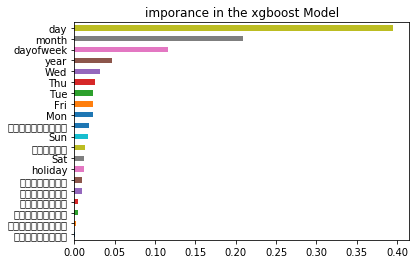

In [55]:
# future importance
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(reg.feature_importances_, index = df_except_y.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

In [ ]:
features =df_merged.columns[df_merged.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in reg._Booster.get_fscore().items()}
xgb.plot_importance(mapped)

In [ ]:
# predict
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

In [ ]:
# create submit file
submit = pd.DataFrame({
    '':df_test['index'],
    '':y_test_pred})
submit.to_csv('../submit/submit_7.tsv',sep='\t')